# Validation curves - Dragnet
This is the continuation to the last notebook, but instead of the cleaneval dataset we'll be using the dragnet one.

In [1]:
%matplotlib inline
# standard library
import itertools
import sys, os
import re
import glob

# pandas
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import dask


# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# skealrn
from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score

# tesnsorflow
import tensorflow as tf

# local imports
sys.path.append(os.path.join(os.getcwd(), "../src"))

import tf_utils
import tf_experiments

# this styling is purely my preference
# less chartjunk
sns.set_context('notebook', font_scale=1.5, rc={'line.linewidth': 2.5})
sns.set(style='ticks', palette='Set2')

## Inputting the data
Using our in-memory caching dataset, we are going to load all the 3 datasets(train, validation, test) in memory.

In [2]:
# get the input functions and the initialization hooks to pass to the estimator
test_input_fn, test_init_hook = tf_utils.input_fn_from_csv('../data/final/dragnet/dom-full-test-*.csv', precache=True)
train_input_fn, train_init_hook = tf_utils.input_fn_from_csv('../data/final/dragnet/dom-full-train-*.csv', precache=True)
validation_input_fn, validation_init_hook = tf_utils.input_fn_from_csv('../data/final/dragnet/dom-full-validation-*.csv', precache=True)

## Defining the model


In [3]:
# session workaround
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = 1

config = tf.estimator.RunConfig(
    model_dir='/home/nikitautiu/dragnet_models',
    save_checkpoints_steps=1000, 
    session_config=sess_config, 
)


# we can infer the columns from the function, a bit costly, but better than hardcoding
tf_feat_cols = tf.contrib.learn.infer_real_valued_columns_from_input_fn(lambda: train_input_fn(num_epochs=1, batch_size=1, shuffle_buffer=0))
estimator = tf.estimator.DNNClassifier(feature_columns=tf_feat_cols, hidden_units=(1000, 500, 200), 
                                        weight_column='weights', model_dir='/home/nikitautiu/dragnet_models', config=config)


INFO:tensorflow:Using config: {'_is_chief': True, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_session_config': gpu_options {
  allow_growth: true
}
, '_task_type': 'worker', '_log_step_count_steps': 100, '_num_ps_replicas': 0, '_model_dir': '/home/nikitautiu/cleaneval_models', '_save_checkpoints_secs': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f48a30b7c88>, '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_master': '', '_service': None, '_tf_random_seed': None}


Now that we have the model, we can build the infrastructure  for testing out the training process and returning the losses and other metrics.

## Train loop
Hacing implemented the helper functions we can now run a training loop for 2000 epochs. To save time, we will evaluate every 5 epochs instead of 1.

In [ ]:
%%time
metrics = tf_experiments.train_eval_loop(estimator, 
                          (lambda: train_input_fn(num_epochs=5, batch_size=3000, shuffle_buffer=100000), train_init_hook),
                          num_epochs=400, epoch_step=5,
                          eval_input_fns_and_hooks= {
                                                        'train':  (lambda: train_input_fn(num_epochs=1, batch_size=5000, shuffle_buffer=0), train_init_hook),
                                                        'validation': (lambda: validation_input_fn(num_epochs=1, batch_size=5000, shuffle_buffer=0), validation_init_hook),
                                                        'test':  (lambda: test_input_fn(num_epochs=1, batch_size=5000, shuffle_buffer=0), test_init_hook),
                                                    })

The time(deleted the output for a more compact display)
```
CPU times: user 10h 34min 23s, sys: 1h 41min, total: 12h 15min 23s
Wall time: 11h 43min 15s
```
## Results and vizualization

In [25]:
validation_stats = pd.DataFrame(metrics['validation'])
train_stats = pd.DataFrame(metrics['train'])
test_stats = pd.DataFrame(metrics['test'])

Print test results for best validation epoch

In [32]:
best_epoch = validation_stats.loc[validation_stats['f1-score'].idxmax(), 'epoch']
best_index = test_stats['epoch'] == best_epoch


print('BEST VALIDATION EPOCH - TEST RESULTS')
print(test_stats[best_index])

BEST VALIDATION EPOCH - TEST RESULTS
     accuracy  epoch  f1-score  precision    recall  support  support_other
351   0.99998   1760  0.999894        1.0  0.999789    14213         138669


### Accuracy

(0.9, 1.01)

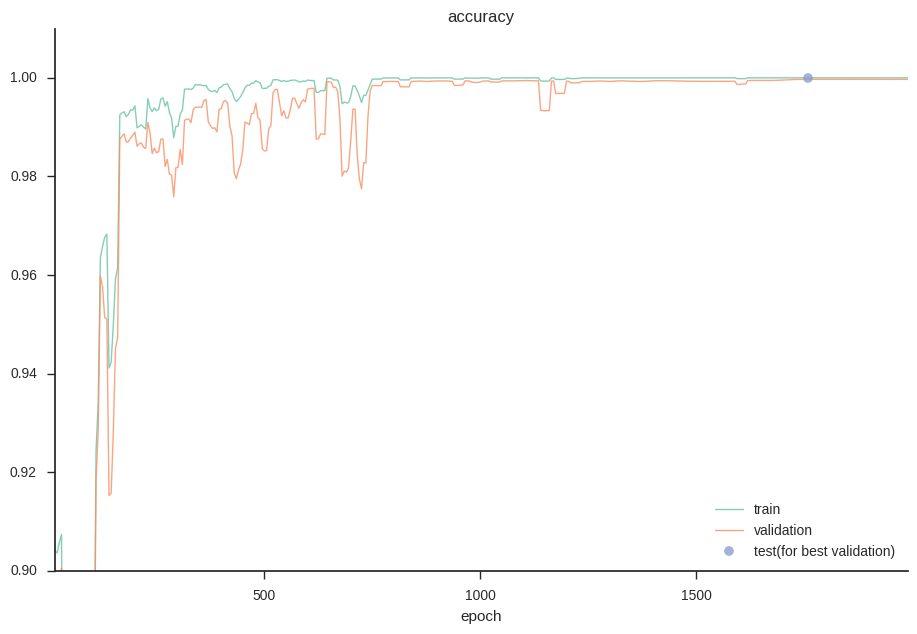

In [73]:
fig, ax = tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'accuracy', smoothing=5)
ax.set_ylim(ymin=0.9)

### Precision/Recall

(0.85, 1.01)

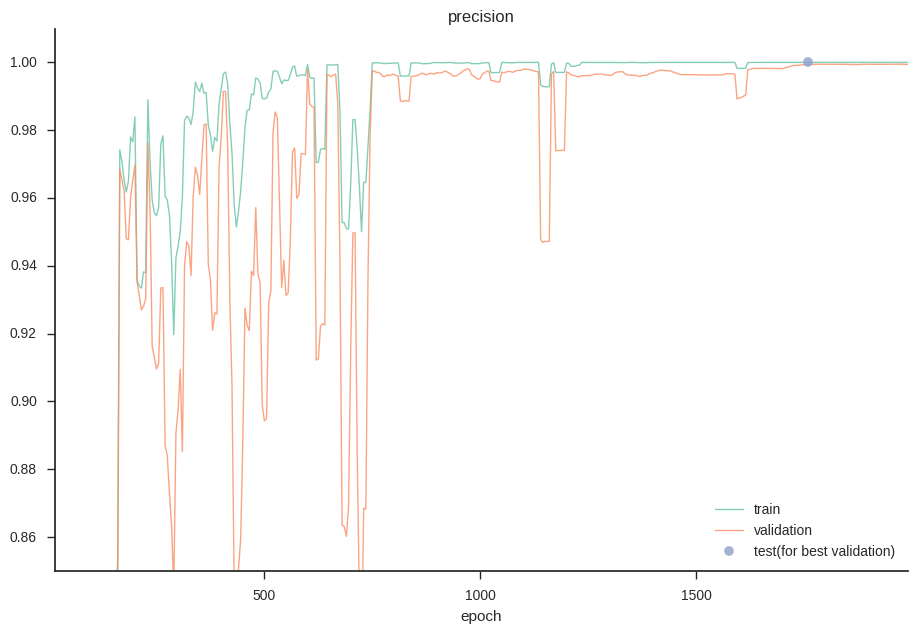

In [102]:
fig, ax = tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'precision', smoothing=5)
ax.set_ylim(ymin=0.85)

(0.8, 1.01)

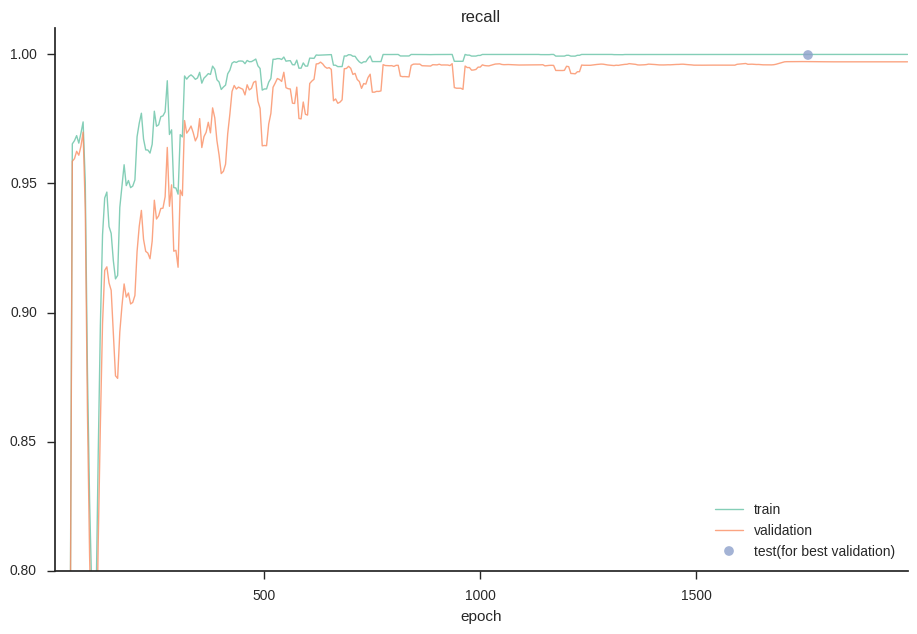

In [72]:
fig, ax = tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'recall', smoothing=5)
ax.set_ylim(ymin=0.8)

### F1-Score

(0.7, 1.01)

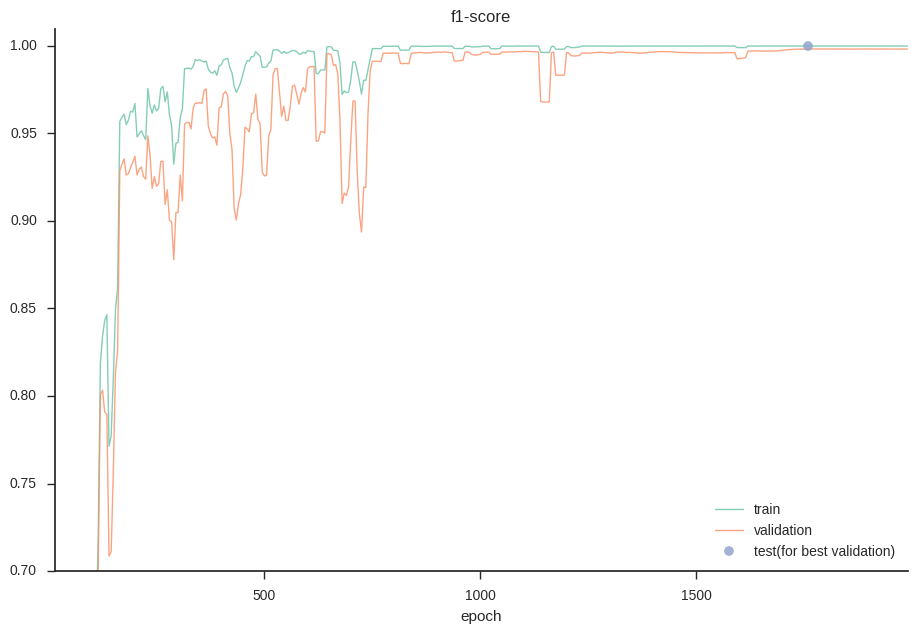

In [71]:
fig, ax = tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'f1-score', smoothing=5)
ax.set_ylim(ymin=0.7)

### Misc stats

In [99]:
# see the best values indxes for validation
indexes = validation_stats.idxmax().reset_index()
epochs = validation_stats['epoch'].iloc[indexes[0]].reset_index(drop=True)

print('BEST EPOCHS FOR EACH MEASURE')
print(indexes.drop(0, axis=1).assign(epoch=epochs).set_index('index').drop(['support', 'support_other']))

BEST EPOCHS FOR EACH MEASURE
           epoch
index           
accuracy    1760
epoch       2000
f1-score    1760
precision    670
recall       690


In [46]:
# also, here are the stats averaged over a rolling window of 50, resample in 50 steps
validation_stats.rolling(1, center=True).mean().dropna().iloc[200::4].set_index('epoch').drop(['support', 'support_other'], axis=1)

,accuracy,f1-score,precision,recall
epoch,,,,
1005.0,0.999408,0.996729,0.997368,0.996091
1025.0,0.999395,0.996661,0.997569,0.995754
1045.0,0.999291,0.996090,0.996292,0.995889
1065.0,0.999298,0.996124,0.996292,0.995956
1085.0,0.999353,0.996426,0.996897,0.995956
1105.0,0.999450,0.996964,0.998041,0.995889
1125.0,0.999389,0.996628,0.997301,0.995956
1145.0,0.999377,0.996560,0.997300,0.995822
1165.0,0.999395,0.996663,0.996898,0.996428


In case we need them later, we will persist the results.

In [47]:
pd.concat([train_stats.assign(set='train'), 
           validation_stats.assign(set='validation'), 
           test_stats.assign(set='test')]).to_csv('../data/experimental-results/dragnet-validation-curves.csv')

## Conclusion
Very good performance and similar validation curves to cleaneval. Slightly slower convergence though and a big dip in performance befor the 500 epoch mark. The dataset might be however less homogenous than cleaneval, as we can see from the bigger gap between validation and train.

Again, accuracy has less noise due to the fact that the dataset is highly skewed. However, here, this even more evident in the very noisy plots of precision and recall which are probably caused by the smaller number of samples being more severly impacted by changes in the model.